# The α algorithm

A [Petri net](https://en.wikipedia.org/wiki/Petri_net) is a graph-based process model with nodes of two types: places and transitions. Places are containers for tokens that may contain zero, one, or more tokens. Transitions are activities. A transition is enabled if all its directly preceding (input) places have at least one token. The transition fires by consuming exactly one token from each input place and producing exactly one token to each output place.

Worfklow net (WF-net) is a Petri net with the designated start and end places and made of a single [connected component](https://en.wikipedia.org/wiki/Component_(graph_theory)). WF-nets are devoted to model business processes. For WF-net, a business case begins when a token is put into the start place. For sound (see Lecture 2) WF-net the process ends when the token appears in the end place. For unsound WF-nets, it may happen that the appearance of the token in the end place does not end the process.

The α algorithm is a very simple algorithm for discovering WF-nets from event logs. See Lecture 6 for the details on the α algorithm.

## Preliminaries

Install PM4Py package and download event logs for exercises.

In [ ]:
!pip install pm4py
!pip install pyvis
!wget http://www.cs.put.poznan.pl/tpawlak/files/EP/RoadTrafficFineManagement.xes.gz

# from google.colab import data_table
# data_table.enable_dataframe_formatter()

# from google.colab import files

In [80]:
from IPython.display import display, IFrame, Markdown

import base64

import pandas as pd
import pm4py

def view_html(filename: str):
  display(IFrame(src="data:text/html;base64," + base64.b64encode(open(filename, "rb").read()).decode("ascii"), width=1000, height=1000))

def printmd(string):
  display(Markdown(string))

## Exercises

Import the `RoadTrafficFineManagement.xes.gz` event log.

In [ ]:
log = pm4py.read_xes("RoadTrafficFineManagement.xes.gz", variant="iterparse20")

integer_features = ["article", "points"]
for feature in integer_features:
  log[feature] = log[feature].astype("Int32")

nominal_features = ["org:resource", "article", "dismissal", "vehicleClass", "notificationType", "lastSent"]
for feature in nominal_features:
  log[feature] = log[feature].astype("string")

log[:10000]

In [ ]:
log[log['totalPaymentAmount'] >= 0.0]['totalPaymentAmount'].hist(bins=100)

In [ ]:
len(log)

Analyze the event log and answer the questions:
* How many traces and events are in the event log?
561470, 150370
* What are the activities in the event log?
'Create Fine', 'Send Fine', 'Insert Fine Notification',
       'Add penalty', 'Send for Credit Collection', 'Payment',
       'Insert Date Appeal to Prefecture', 'Send Appeal to Prefecture',
       'Receive Result Appeal from Prefecture',
       'Notify Result Appeal to Offender', 'Appeal to Judge'
* What is the time window for the event log?
Timestamp('2000-01-01 00:00:00+0000', tz='UTC')-Timestamp('2013-06-18 00:00:00+0000', tz='UTC')
* Which activities start and end the process?
start: Create Fine, end: Send Fine, Payment
* What resources are involved in individual activities?
561	Create Fine
* What is the distribution of fine amount?
prawoskośny

In [ ]:
# n_traces = # TODO: calculate number of traces
# print(f"# traces: {n_traces}")

# n_events = # TODO: calculate number of events
# print(f"# events: {n_events} ({float(n_events)/n_traces} per trace)")

# timestamp_attribute = "" # TODO: set the name of the attribute holding time information
# beginning = log[timestamp_attribute].min()
# end = log[timestamp_attribute].max()
# print(f"Time window: {beginning} - {end} ({end - beginning})")

activity_attribute = "concept:name" # TODO: set the name of the attribute holding the activity name
activities = log.groupby(activity_attribute)[activity_attribute].count()
printmd("**Acitivites:**")
display(activities)

# start_activities = pm4py... # TODO: find start activities
# end_activities = pm4py... # TODO: find end activities
# printmd("**Start activities:**")
# print(", ".join(start_activities.keys()))
# printmd("**End activities:**")
# print(", ".join(end_activities.keys()))

resource_attribute = "org:resource" # TODO: set the name of the attribute holding the employee identifier
activities_resources = log.groupby(activity_attribute)[resource_attribute].unique()
printmd("**Resources assigned to activities:**")
display(activities_resources)

fine_amount = "amount" # TODO: set the name of the attribute holding the fine amount
printmd("**Fine amount distribution:**")
log[fine_amount].dropna().describe()

How do look like the most common process variants?
**Draw on a piece of paper the general structure of the process that reproduces at least 90% of the most common behavior.**

Do people usually pay fines or not?

In [88]:
variants = pm4py.get_variants(log) # TODO: group event log into variants
common_variants = pd.DataFrame(variants.items(), columns=["variant", "count"]).sort_values("count", ascending=False)
common_variants["percentile"] = common_variants["count"] * 100 / common_variants["count"].sum()
common_variants

,variant,count,percentile
1,"(Create Fine, Send Fine, I...",56482,37.562014
4,"(Create Fine, Payment)",46371,30.837933
0,"(Create Fine, Send Fine)",20385,13.556560
2,"(Create Fine, Send Fine, I...",9520,6.331050
5,"(Create Fine, Send Fine, I...",3736,2.484538
...,...,...,...
157,"(Create Fine, Send Fine, I...",1,0.000665
156,"(Create Fine, Send Fine, I...",1,0.000665
155,"(Create Fine, Send Fine, I...",1,0.000665
79,"(Create Fine, Send Fine, I...",1,0.000665


In [90]:
pd.set_option('display.max_colwidth', None)
print(common_variants['variant'].head(30))
pd.set_option('display.max_colwidth', 30)

1                                                                                                                                           (Create Fine, Send Fine, Insert Fine Notification, Add penalty, Send for Credit Collection)
4                                                                                                                                                                                                                (Create Fine, Payment)
0                                                                                                                                                                                                              (Create Fine, Send Fine)
2                                                                                                                                                              (Create Fine, Send Fine, Insert Fine Notification, Add penalty, Payment)
5                                                                       

Use the basic version of the α algorithm to discover the WF-net for the road fine management process using the entire event log. Answer the questions:
* Is the resulting WF-net sound?
* Does it represent well the process?
* What are the deficiencies of this model?

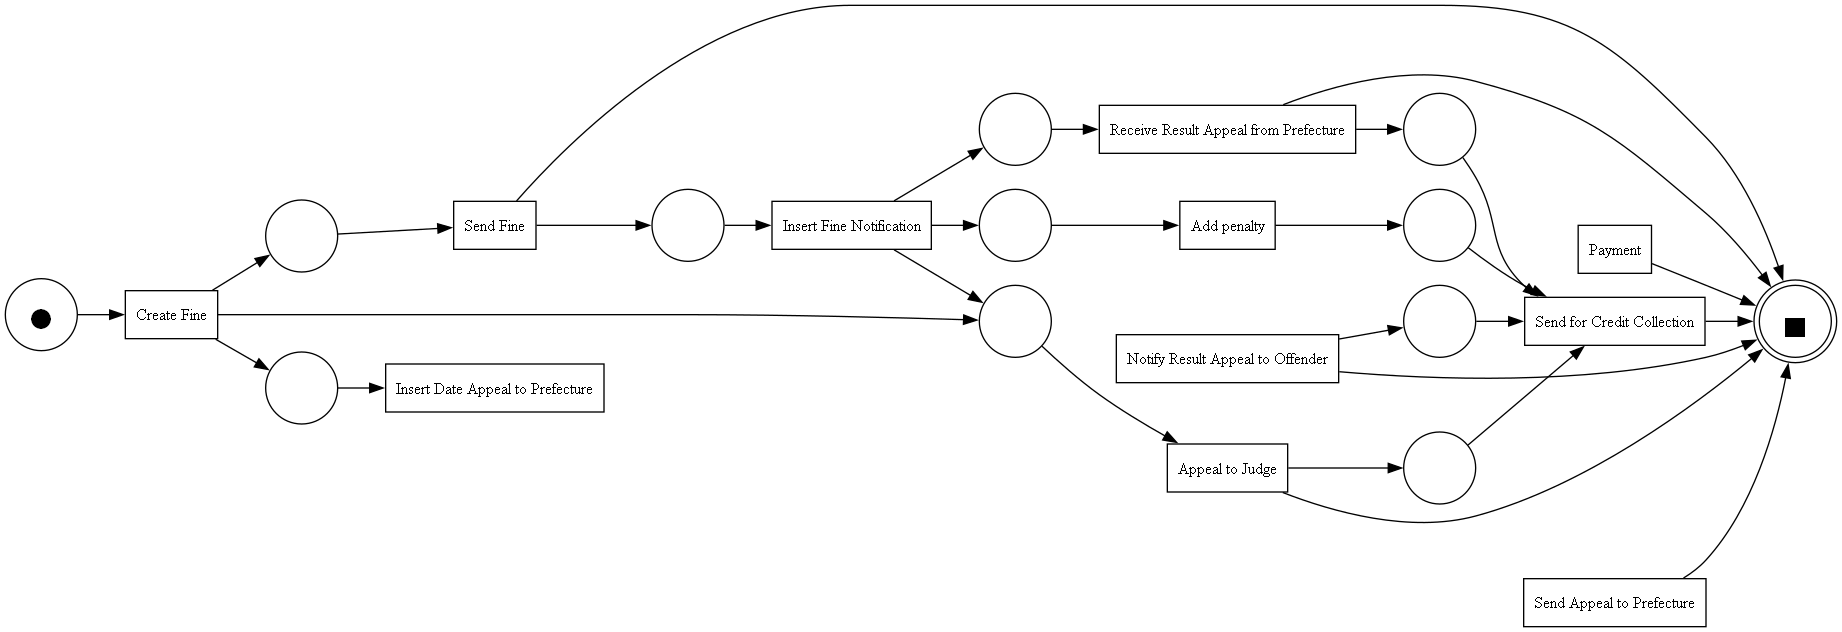

In [92]:
wfnet_alpha = pm4py.discover_petri_net_alpha(log) # TODO: discover WF-net using the α algorithm
pm4py.vis.view_petri_net(*wfnet_alpha)

Verify algorithmically the soundness of the WF-net created by the α algorithm.

In [93]:
from pm4py.algo.analysis.woflan import algorithm as woflan

woflan_parameters = {
    woflan.Parameters.RETURN_ASAP_WHEN_NOT_SOUND: False,
    woflan.Parameters.PRINT_DIAGNOSTICS: True,
    woflan.Parameters.RETURN_DIAGNOSTICS: False
}

is_sound = woflan.apply(*wfnet_alpha, parameters=woflan_parameters)
print(f"Is sound: {is_sound}")

Input is ok.
Petri Net is a not a worflow net.
Is sound: False


The α algorithm is unable to handle loops of length of 1 and 2.
**α+ algorithm** is an extension of the α algorithm that handles well loops of length 1 and 2.

Do the same exercises using the α+ algorithm and answer the same questions about the resulting WF-net.

Which algorithm produces better results?

C:\Users\macie\AppData\Local\Temp\ipykernel_11828\1857889410.py:1: DeprecatedWarning: discover_petri_net_alpha_plus is deprecated as of 2.3.0 and will be removed in 3.0.0. This method will be removed in a future release.
  wfnet_alphap = pm4py.discover_petri_net_alpha_plus(log) # TODO: discover WF-net using the α+ algorithm


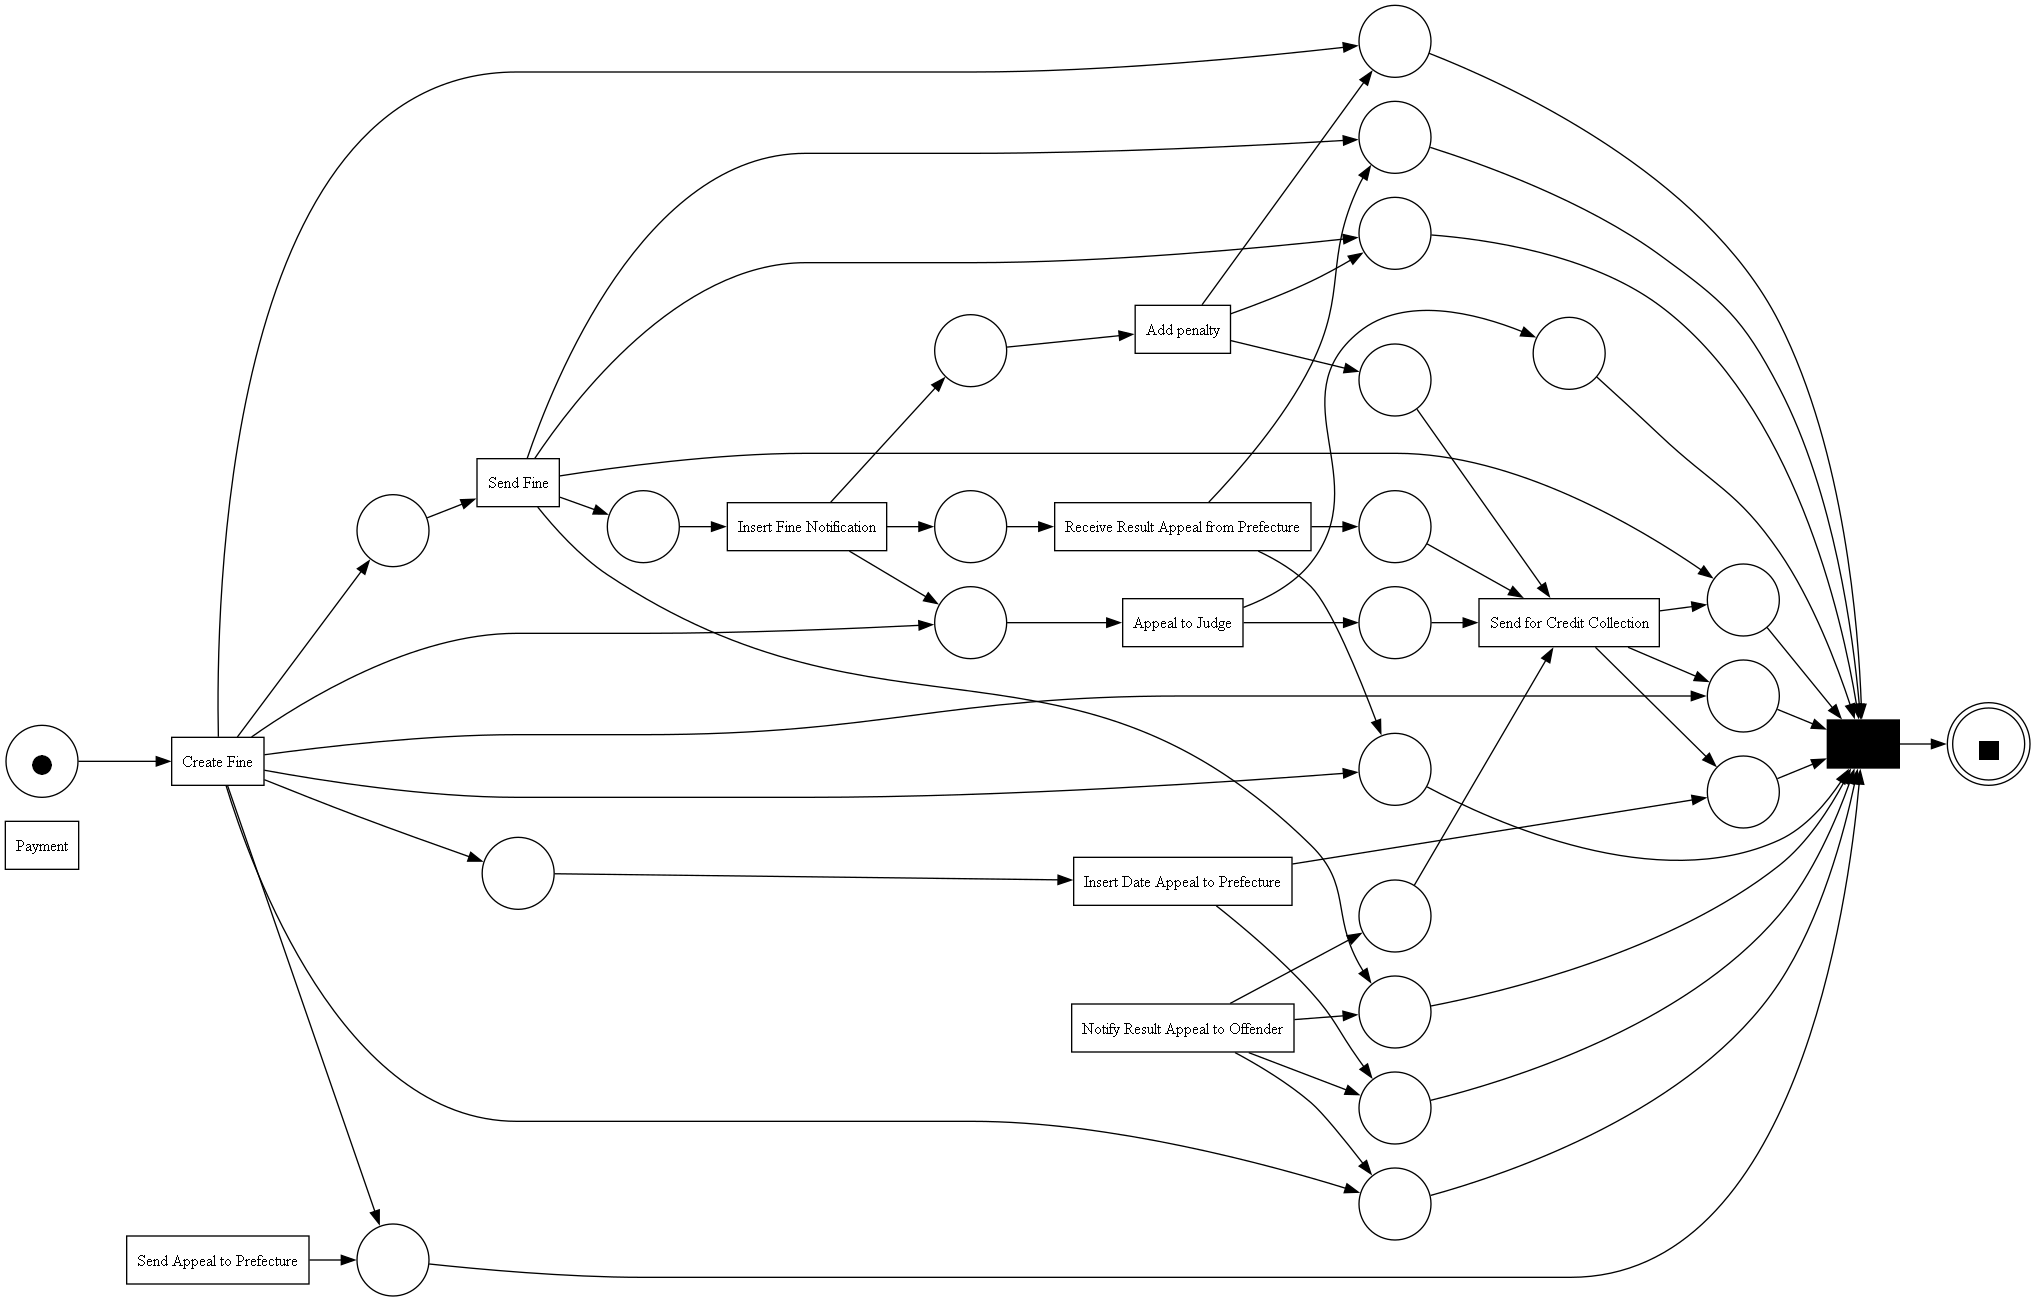

In [94]:
wfnet_alphap = pm4py.discover_petri_net_alpha_plus(log) # TODO: discover WF-net using the α+ algorithm
pm4py.vis.view_petri_net(*wfnet_alphap)

Verify algorithmically the soundness of the WF-net created by the α+ algorithm.

In [95]:
from pm4py.algo.analysis.woflan import algorithm as woflan

woflan_parameters = {
    woflan.Parameters.RETURN_ASAP_WHEN_NOT_SOUND: False,
    woflan.Parameters.PRINT_DIAGNOSTICS: True,
    woflan.Parameters.RETURN_DIAGNOSTICS: False
}

is_sound = woflan.apply(*wfnet_alphap, parameters=woflan_parameters)
print(f"Is sound: {is_sound}")

Input is ok.
Petri Net is a not a worflow net.
Is sound: False


Build a WF-net using 80% of most common variants in the log. Is the WF-net sound?

What is the result for 90% of the most common variants?

,variant,count,percentile
1,"(Create Fine, Send Fine, I...",56482,37.562014
4,"(Create Fine, Payment)",46371,30.837933
0,"(Create Fine, Send Fine)",20385,13.556560


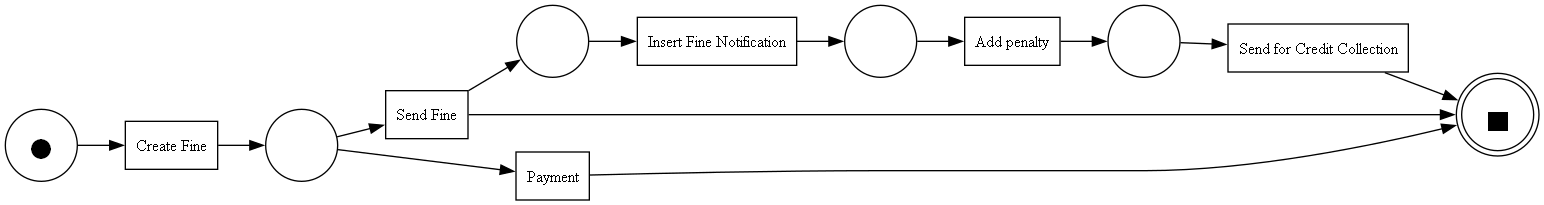

In [96]:
k = 3 # TODO the number of top common variants that sum up to > 80% of behavior
display(common_variants[0:k])

log_top_k = pm4py.filter_variants_top_k(log, k) # TODO: filter top k variants
wfnet_alphap_topk = pm4py.discover_petri_net_alpha(log_top_k) # TODO: discover WF-net using the α algorithm
pm4py.vis.view_petri_net(*wfnet_alphap_topk)

Verify algorithmically the soundness of the above WF-net.

In [97]:
from pm4py.algo.analysis.woflan import algorithm as woflan

woflan_parameters = {
    woflan.Parameters.RETURN_ASAP_WHEN_NOT_SOUND: False,
    woflan.Parameters.PRINT_DIAGNOSTICS: True,
    woflan.Parameters.RETURN_DIAGNOSTICS: False
}

is_sound = woflan.apply(*wfnet_alphap_topk, parameters=woflan_parameters)
print(f"Is sound: {is_sound}")

Input is ok.
Petri Net is a workflow net.
The following places are not covered by an s-component: [({'Add penalty'}, {'Send for Credit Collection'}), ({'Create Fine'}, {'Send Fine', 'Payment'}), ({'Insert Fine Notification'}, {'Add penalty'}), ({'Send Fine'}, {'Insert Fine Notification'}), end, start].
Not well-handled pairs are: [(11, 4)].
The following places are uncovered in uniform invariants: [({'Add penalty'}, {'Send for Credit Collection'}), ({'Create Fine'}, {'Send Fine', 'Payment'}), ({'Insert Fine Notification'}, {'Add penalty'}), ({'Send Fine'}, {'Insert Fine Notification'}), end, start]
The following places are uncovered in weighted invariants: [({'Add penalty'}, {'Send for Credit Collection'}), ({'Create Fine'}, {'Send Fine', 'Payment'}), ({'Insert Fine Notification'}, {'Add penalty'}), ({'Send Fine'}, {'Insert Fine Notification'}), end, start]
Improper WPD. The following are the improper conditions: [0].
The following sequences are unbounded: [[(Create Fine, 'Create Fine'

**Comment to the output of verification**

An S-component of a Petri net is a subnet such that, for each place of the subnet, all input- and output-transitions belong to the subnet as well, and such that each transition of the subnet has exactly one input- and exactly one output-place of the subnet. It is immediate to see that the number of tokens in an S-component never changes. A net is covered by S-components if each place and each transition belongs to an S-component. Nets covered by S-components carrying exactly one token are necessarily 1-safe. For example, every live and 1-safe free-choice net enjoys this nice property [1].

Invariants are parts of the net that do not change the weighted sum/total number of tokens in the total.

[1] Jörg Desel, Javier Esparza, Negotiations and Petri Nets, https://ceur-ws.org/Vol-1372/paper3.pdf

Try making a WF-net for 80% and 90% of most common variants in the log using the Inductive Miner algorithm.

,variant,count,percentile
1,"(Create Fine, Send Fine, I...",56482,37.562014
4,"(Create Fine, Payment)",46371,30.837933
0,"(Create Fine, Send Fine)",20385,13.556560
2,"(Create Fine, Send Fine, I...",9520,6.331050
5,"(Create Fine, Send Fine, I...",3736,2.484538


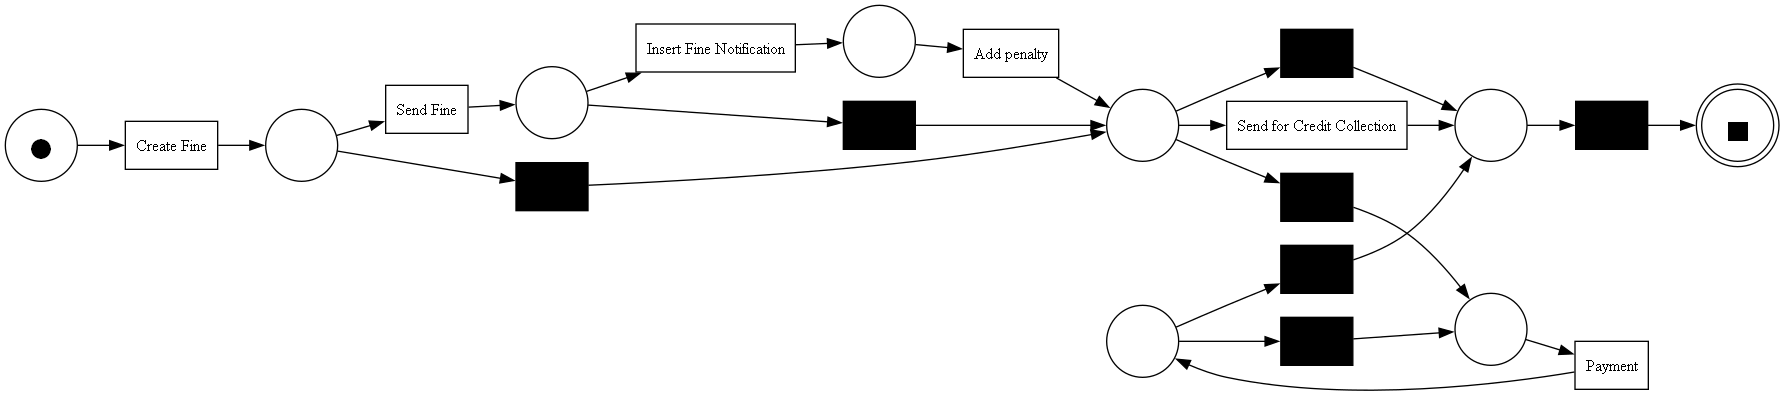

Input is ok.
Petri Net is a workflow net.
Every place is covered by s-components.
There are no dead tasks.
All tasks are live.
Is sound: True


In [100]:
k = 5 # TODO: the number of top common variants that sum up to > 80% of behavior
display(common_variants[0:k])

log_top_k = pm4py.filter_variants_top_k(log, k) # TODO: filter top k variants

wfnet_inductive = pm4py.discover_petri_net_inductive(log_top_k) # TODO: discover WF-net using the Inductive Miner
pm4py.vis.view_petri_net(*wfnet_inductive)

from pm4py.algo.analysis.woflan import algorithm as woflan

woflan_parameters = {
    woflan.Parameters.RETURN_ASAP_WHEN_NOT_SOUND: False,
    woflan.Parameters.PRINT_DIAGNOSTICS: True,
    woflan.Parameters.RETURN_DIAGNOSTICS: False
}

is_sound = woflan.apply(*wfnet_inductive, parameters=woflan_parameters) # TODO: check soundness
print(f"Is sound: {is_sound}")

Pick the model that you feel is the best and replay the log on it to add frequences of events/activities, and temporal information.

c:\Users\macie\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
replaying log with TBR, completed traces :: 100%|██████████| 231/231 [00:02<00:00, 98.00it/s] 


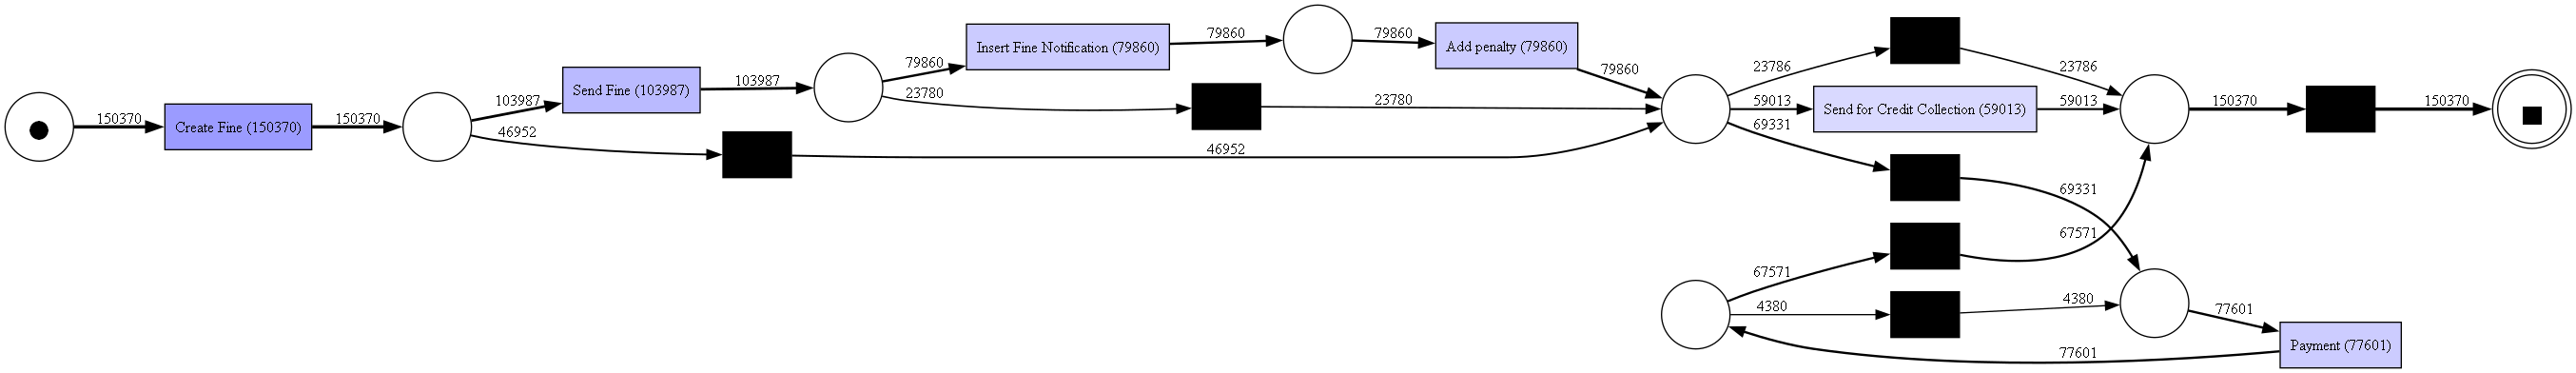

replaying log with TBR, completed traces :: 100%|██████████| 231/231 [00:02<00:00, 103.93it/s]


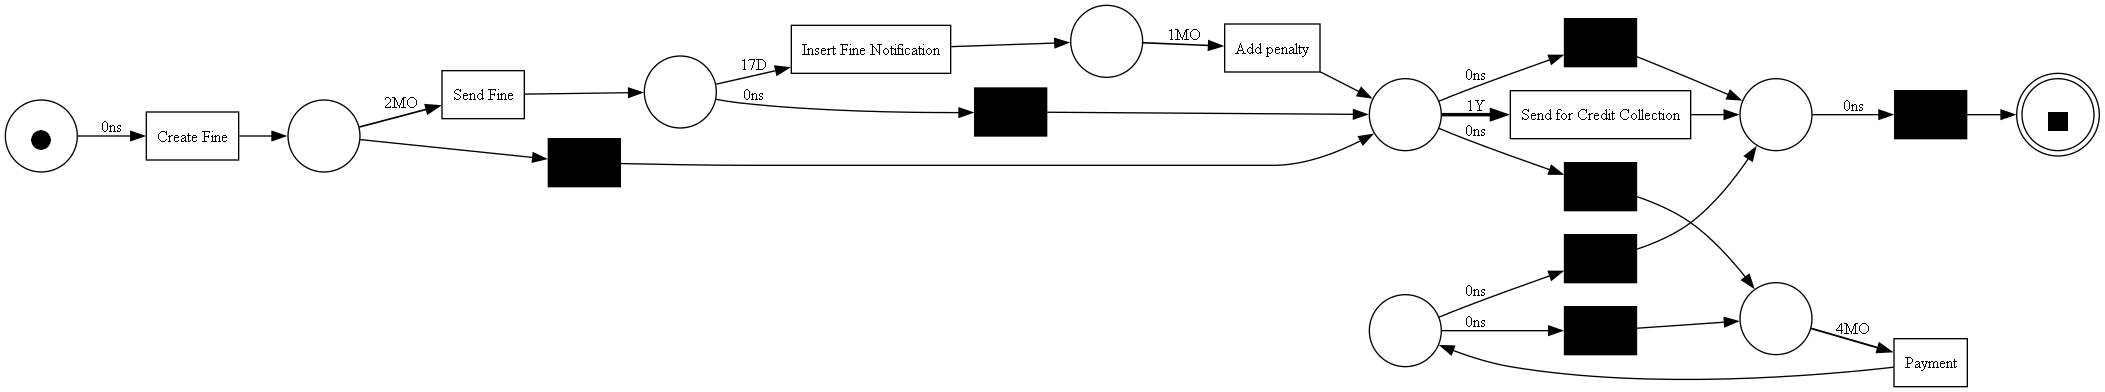

In [101]:
from pm4py.visualization.petri_net import visualizer as pn_visualizer

net = wfnet_inductive # TODO: set WF-net that you feel the best

# add frequencies
parameters_freq = {pn_visualizer.Variants.FREQUENCY.value.Parameters.FORMAT: "png"}
gviz_freq = pn_visualizer.apply(*net, parameters=parameters_freq, variant=pn_visualizer.Variants.FREQUENCY, log=log)
pn_visualizer.view(gviz_freq)

# add temporal information
parameters_temp = {pn_visualizer.Variants.PERFORMANCE.value.Parameters.FORMAT: "png"}
gviz_temp = pn_visualizer.apply(*net, parameters=parameters_temp, variant=pn_visualizer.Variants.PERFORMANCE, log=log)
pn_visualizer.view(gviz_temp)

Calculate fitness, precision, generalization, and simplicity for the best WF-net.

In [ ]:
from pm4py.algo.evaluation.generalization import algorithm as generalization_evaluator
from pm4py.algo.evaluation.simplicity import algorithm as simplicity_evaluator

net = wfnet_inductive

fitness = pm4py.fitness_alignments(log, *net) # TODO: calculate fitness using alignments
precision = pm4py.precision_alignments(log, *net) # TODO: calculate precision using alignments
generalization = generalization_evaluator.token_based.apply(log, *net) # TODO: calculate generalization using token-based replay
simplicity = simplicity_evaluator.apply(net[0]) # TODO: calculate simplicity; what kind of measure is it?

print(f"Fitness: {fitness}")
print(f"Precision: {precision}")  # 22 % przypadków nie ma w logu
print(f"Generalization: {generalization}")
print(f"Simplicity: {simplicity}")

aligning log, completed variants :: 100%|██████████| 231/231 [00:01<00:00, 143.47it/s]
computing precision with alignments, completed variants :: 100%|██████████| 271/271 [00:00<00:00, 383.25it/s]
replaying log with TBR, completed traces :: 100%|██████████| 231/231 [00:03<00:00, 70.35it/s] 


Fitness: {'percFitTraces': 92.94939150096428, 'averageFitness': 0.9847142758459049, 'percentage_of_fitting_traces': 92.94939150096428, 'average_trace_fitness': 0.9847142758459049, 'log_fitness': 0.9762217598901293}
Precision: 0.7840136007203866
Generalization: 0.9951245632266205
Simplicity: 0.7333333333333333


Replay each trace on this model using the alignment algorithm and visualize the result of conformance check.

In [ ]:
alignments = pm4py... # TODO: calculate alignments of the log and model
pm4py.vis.view_alignments(log, alignments)

Explain decisions in the best WF-net using decision trees induced by replaying the event log on the WF-net.
For performance reasons sample at most 2000 traces from the entire event log.

Interpret the resulting decision trees in the context of the decision points.

In [ ]:
from pm4py.algo.decision_mining import algorithm as decision_mining
from pm4py.visualization.petri_net import visualizer
from pm4py.visualization.decisiontree import visualizer as tree_visualizer
from sklearn import tree

net =  # TODO: set the WF-net that you feel the best

# View the WF-net
pm4py.view_petri_net(*net)
# View the identifiers of the nodes in the WF-net
gviz = visualizer.apply(*net, parameters={visualizer.Variants.WO_DECORATION.value.Parameters.DEBUG: True})
visualizer.view(gviz)

# Sample the event log for performance reasons
log_sample = pm4py... # TODO: sample 2000 traces from the event log

decision_points = decision_mining... # TODO: get decision points
for point in sorted(decision_points.keys()):
  X, y, classes = decision_mining.apply(log_sample, *net, decision_point=point)
  X = X.fillna(0)
  X = X[~y.isna()]
  y = y[~y.isna()]
  classes = [str(c) for c in classes]

  print(f"Decision point: {point}; possible decisions: {classes}")

  dt = tree.DecisionTreeClassifier(max_depth=10, ccp_alpha=0.005)
  dt = dt.fit(X, y)
  feature_names = list(X.columns.values.tolist())

  gviz = tree_visualizer.apply(dt, feature_names, classes)
  tree_visualizer.view(gviz)